In [1]:

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


In [2]:
DATA_DIR = './dataset/'

# load repo with data if it is not exists


In [3]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'valid')
y_valid_dir = os.path.join(DATA_DIR, 'validannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

x_md2_dir=os.path.join(DATA_DIR, 'md_images2')
y_md2_dir=os.path.join(DATA_DIR, 'md_annot2')

x_md_dir=os.path.join(DATA_DIR, 'md_images')
y_md_dir=os.path.join(DATA_DIR, 'md_annot')

x_testkaggle_dir = os.path.join(DATA_DIR, 'test_kaggle')
y_testkaggle_dir = os.path.join(DATA_DIR, 'test_kaggleannot')

x_mdkaggle_dir=os.path.join(DATA_DIR, 'md_imageskaggle')
y_mdkaggle_dir=os.path.join(DATA_DIR, 'md_annotkaggle')

x_kaggle_img_dir='../airbus-ship-detection/input/test_segmentation/images'
y_kaggle_img_dir='../airbus-ship-detection/input/test_segmentation/labels'

x_testkaggle2_dir = os.path.join(DATA_DIR, 'test_kaggle2')
y_testkaggle2_dir = os.path.join(DATA_DIR, 'test_kaggle2annot')

x_img_detail_dir = os.path.join(DATA_DIR, 'img_completa')
y_img_detail_dir = os.path.join(DATA_DIR, 'img_completa_annot')

x_testkaggle4_dir = os.path.join(DATA_DIR, 'test_kaggle4')
y_testkaggle4_dir = os.path.join(DATA_DIR, 'test_kaggle4annot')

x_testbb4_dir = '../airbus-ship-detection/input/test_segmentation4/cut_images/'
y_testbb4_dir = '../airbus-ship-detection/input/test_segmentation4/cut_annot/'

x_testbb2_dir = '../airbus-ship-detection/input/test_segmentation2/cut_images/'
y_testbb2_dir = '../airbus-ship-detection/input/test_segmentation2/cut_annot/'

x_testbb_dir = '../airbus-ship-detection/input/test_segmentation/cut_images/'
y_testbb_dir = '../airbus-ship-detection/input/test_segmentation/cut_annot/'

x_testbbseagull_dir = '../../dataset_segmentation/cut_images2/'
y_testbbseagull_dir = '../../dataset_segmentation/cut_annot2/'

x_trainmasati_dir = '../../masati_treino/train_masati/'
y_trainmasati_dir = '../../masati_treino/trainannot_masati/'

x_validmasati_dir = '../../masati_treino/valid_masati/'
y_validmasati_dir = '../../masati_treino/validannot_masati/'

x_trainkaggle2_dir = '../airbus-ship-detection/input/train_seg2/train/'
y_trainkaggle2_dir = '../airbus-ship-detection/input/train_seg2/trainannot/'

x_validkaggle2_dir = '../airbus-ship-detection/input/train_seg2/valid/'
y_validkaggle2_dir = '../airbus-ship-detection/input/train_seg2/validannot/'

x_challenge_dir = '../airbus-ship-detection/input/challenge/cut_images/'
y_challenge_dir = '../airbus-ship-detection/input/challenge/cut_annot/'

In [4]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['boat']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i],0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

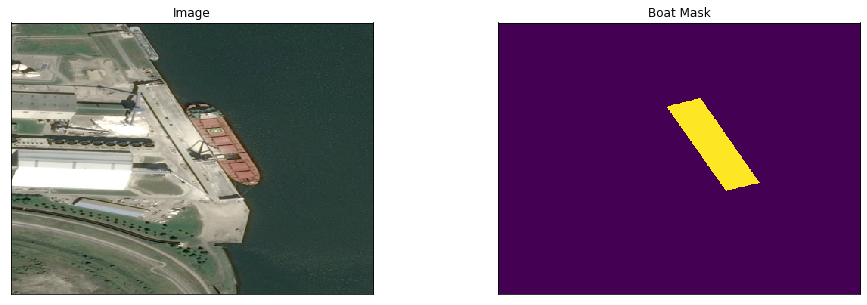

071aa6ab2_1.png


In [5]:
dataset = Dataset(x_trainkaggle2_dir, y_trainkaggle2_dir, classes=['boat'])

image, mask = dataset[10] # get some sample
visualize(
    image=image, 
    boat_mask=mask[..., 0].squeeze(),
    #background_mask=mask[..., 1].squeeze(),  
    
)
print(dataset.ids[10])

In [6]:
import albumentations as A


In [7]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.RandomCrop(height=320, width=320, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        #A.PadIfNeeded(384, 480)
        A.PadIfNeeded(32, 32)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

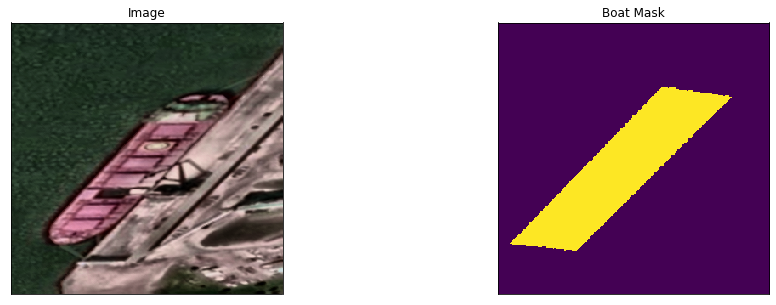

071aa6ab2_1.png


In [8]:
# Lets look at augmented data we have
dataset = Dataset(x_trainkaggle2_dir, y_trainkaggle2_dir, classes=['boat'], augmentation=get_training_augmentation())

image, mask = dataset[10] # get some sample
visualize(
    image=image, 
    boat_mask=mask[..., 0].squeeze(),
    #background_mask=mask[..., 1].squeeze()
)
print(dataset.ids[10])

In [9]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [10]:
BACKBONE = 'densenet121'
BATCH_SIZE = 16
CLASSES = ['boat']
LR = 0.0001
EPOCHS = 10

preprocess_input = sm.get_preprocessing(BACKBONE)

In [11]:
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

In [12]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [13]:

# Dataset for train images
train_dataset = Dataset(
    x_trainkaggle2_dir, 
    y_trainkaggle2_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_validkaggle2_dir, 
    y_validkaggle2_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 320, 320, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 320, 320, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./resnet18_kaggle2.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [14]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=20, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/20
 11/121 [=>............................] - ETA: 36:46 - loss: 1.0903 - iou_score: 0.0128 - f1-score: 0.0248

KeyboardInterrupt: 

In [ ]:
model.load_weights('./resnet18_masati.h5')

In [38]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=8, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/8
31/31 [==============================] - 1051s 34s/step - loss: 0.8840 - iou_score: 0.1272 - f1-score: 0.1940 - val_loss: 1.0000 - val_iou_score: 0.7628 - val_f1-score: 0.7802
Epoch 2/8
31/31 [==============================] - 1190s 38s/step - loss: 0.8242 - iou_score: 0.1851 - f1-score: 0.2631 - val_loss: 1.0000 - val_iou_score: 0.8161 - val_f1-score: 0.8328
Epoch 3/8
31/31 [==============================] - 1102s 36s/step - loss: 0.8166 - iou_score: 0.1797 - f1-score: 0.2648 - val_loss: 1.0000 - val_iou_score: 0.8116 - val_f1-score: 0.8282
Epoch 4/8
31/31 [==============================] - 1109s 36s/step - loss: 0.8079 - iou_score: 0.1847 - f1-score: 0.2664 - val_loss: 1.0000 - val_iou_score: 0.8301 - val_f1-score: 0.8465
Epoch 5/8
31/31 [==============================] - 1008s 33s/step - loss: 0.8228 - iou_score: 0.1675 - f1-score: 0.2506 - val_loss: 1.0000 - val_iou_score: 0.8215 - val_f1-score: 0.8387
Epoch 6/8
31/31 [==============================] - 944s 30s/step - los

In [ ]:

# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [15]:
thresholds=[0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]
model.load_weights('./seresnet18_best_model.h5')
for i in thresholds:
    # define optomizer
    optim = keras.optimizers.Adam(LR)

    # Segmentation models losses can be combined together by '+' and scaled by integer or float factor
    dice_loss = sm.losses.DiceLoss()
    focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
    total_loss = dice_loss + (1 * focal_loss)

    # actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
    # total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

    metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(beta=2,threshold=i)]

    # compile keras model with defined optimozer, loss and metrics
    model.compile(optim, total_loss, metrics)
    
    test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
    )

    test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)
    scores = model.evaluate_generator(test_dataloader)
    print("Dataset Seagull")
    print("thresholds: "+str(i))
    print("Loss: {:.5}".format(scores[0]))
    for metric, value in zip(metrics, scores[1:]):
        print("mean {}: {:.5}".format(metric.__name__, value))
    
    test_dataset = Dataset(
    x_testkaggle_dir, 
    y_testkaggle_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
    )

    test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)
    scores = model.evaluate_generator(test_dataloader)
    print("Dataset Kaggle")
    print("thresholds: "+str(i))
    print("Loss: {:.5}".format(scores[0]))
    for metric, value in zip(metrics, scores[1:]):
        print("mean {}: {:.5}".format(metric.__name__, value))

Dataset Seagull
thresholds: 0.5
Loss: 1.0
mean iou_score: 0.93656
mean f2-score: 0.94858
Dataset Kaggle
thresholds: 0.5
Loss: 1.0
mean iou_score: 0.90243
mean f2-score: 0.91172
Dataset Seagull
thresholds: 0.55
Loss: 1.0
mean iou_score: 0.93656
mean f2-score: 0.95043
Dataset Kaggle
thresholds: 0.55
Loss: 1.0
mean iou_score: 0.90243
mean f2-score: 0.91152
Dataset Seagull
thresholds: 0.6
Loss: 1.0
mean iou_score: 0.93656
mean f2-score: 0.95027
Dataset Kaggle
thresholds: 0.6
Loss: 1.0
mean iou_score: 0.90243
mean f2-score: 0.91129
Dataset Seagull
thresholds: 0.65
Loss: 1.0
mean iou_score: 0.93656
mean f2-score: 0.95004
Dataset Kaggle
thresholds: 0.65
Loss: 1.0
mean iou_score: 0.90243
mean f2-score: 0.91104
Dataset Seagull
thresholds: 0.7
Loss: 1.0
mean iou_score: 0.93656
mean f2-score: 0.94984
Dataset Kaggle
thresholds: 0.7
Loss: 1.0
mean iou_score: 0.90243
mean f2-score: 0.91077
Dataset Seagull
thresholds: 0.75
Loss: 1.0
mean iou_score: 0.93656
mean f2-score: 0.94961
Dataset Kaggle
thresh

In [35]:
%%time
model.load_weights('./resnet18_masati.h5')
test_dataset = Dataset(
    x_testbb_dir, 
    y_testbb_dir, 
    classes=CLASSES,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
    )
    
test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

total_score=0

for i in range(len(test_dataset)):
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    intersection = np.sum(gt_mask * pr_mask[0])
    union = np.sum(gt_mask + pr_mask[0]) - intersection
    if union==0:
        score=1
    else:
        score = (intersection) / (union)
    total_score+=score
print(total_score/len(test_dataset))

0.8998115960435863
Wall time: 10.6 s


In [26]:
##testar só imagens que têm barcos
model.load_weights('./resnet18_masati.h5')
test_dataset = Dataset(
    x_testbb4_dir, 
    y_testbb4_dir, 
    classes=CLASSES,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
    )
    
test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

total_score=0
count=0
for i in range(len(test_dataset)):
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)    
    if np.sum(gt_mask)!=0:
        pr_mask = model.predict(image).round()
        count+=1
        intersection = np.sum(gt_mask * pr_mask[0])
        union = np.sum(gt_mask + pr_mask[0]) - intersection
        if union==0:
            score=1
        else:
            score = (intersection) / (union)
        total_score+=score
print(count)
print(total_score/count)

44
0.33860296936692735


In [16]:
##testar só imagens que pr_mask diferente de zero
model.load_weights('./resnet18_masati.h5')
test_dataset = Dataset(
    x_testbb4_dir, 
    y_testbb4_dir, 
    classes=CLASSES,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
    )
    
test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

total_score=0
count=0
for i in range(len(test_dataset)):
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)    
    
    pr_mask = model.predict(image).round()
    if np.sum(pr_mask)!=0:    
        count+=1
        intersection = np.sum(gt_mask * pr_mask[0])
        union = np.sum(gt_mask + pr_mask[0]) - intersection
        if union==0:
            score=1
        else:
            score = (intersection) / (union)
        total_score+=score
print(count)
print(total_score/count)

61
0.2442382074122099


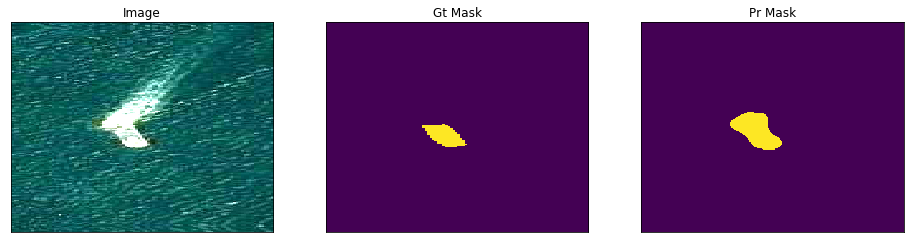

In [20]:
model.load_weights('./resnet18/resnet18_best_model.h5')
test_dataset = Dataset(
    x_testkaggle2_dir, 
    y_testkaggle2_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
    )

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

n = 1
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )


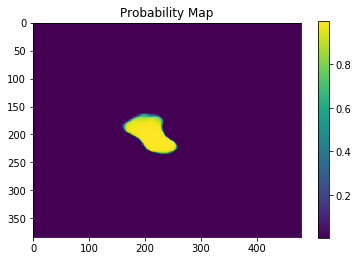

In [21]:
pr_mask = model.predict(image)

#f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    


probability_graph = plt.imshow(pr_mask[..., 0].squeeze())
plt.title('Probability Map')
plt.colorbar(probability_graph)

plt.show()



In [14]:
import pydensecrf.densecrf as dcrf

from pydensecrf.utils import compute_unary, create_pairwise_bilateral, \
    create_pairwise_gaussian, softmax_to_unary, unary_from_softmax

import skimage.io as io

In [23]:
test=1-pr_mask
print(test[0].shape)

print(test.shape)
a=[]
a.append(test[0])
a.append(pr_mask[0])

arr = np.array(a).squeeze() 
print(arr.shape)

img = image[0]

print(img.shape)
print(img.dtype)

(384, 480, 1)
(1, 384, 480, 1)
(2, 384, 480)
(384, 480, 3)
uint8


In [24]:
softmax=arr
unary = softmax_to_unary(softmax)
unary = np.ascontiguousarray(unary
unary = unary.reshape((2,-1))

(2, 384, 480)
(2, 184320)
(2, 184320)


In [39]:

d = dcrf.DenseCRF(img.shape[0]* img.shape[1], 2)
d.setUnaryEnergy(unary)

mu1 = 1
theta_a = 0.5
theta_b = 1
mu2 = 2
theta_r = 3

feats = create_pairwise_bilateral(sdims=(theta_a, theta_a), schan=(theta_b,), img=img,  chdim=2)
d.addPairwiseEnergy(feats, compat=mu1, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

feats = create_pairwise_gaussian(sdims=(theta_r, theta_r), shape=img.shape[:2])
d.addPairwiseEnergy(feats, compat=mu2, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

Q = d.inference(10)
res1 = np.argmax(Q, axis=0).astype('float32').reshape((img.shape[0], img.shape[1]))
#res1 = np.reshape(res1, img.shape).astype(dtype='int8')


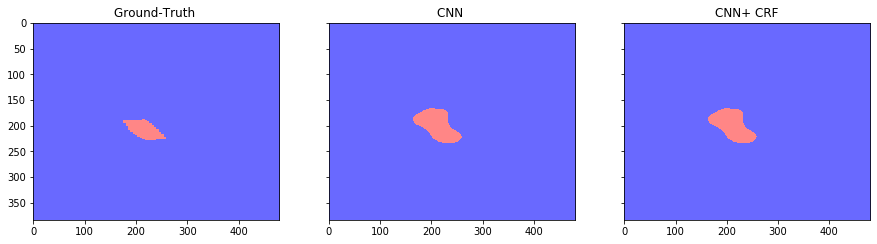

In [40]:
cmap1 = plt.get_cmap('bwr')

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,15))

ax1.imshow(gt_mask[..., 0].squeeze().round(), vmax=1.5, vmin=-0.4, cmap=cmap1)
ax1.set_title('Ground-Truth ')

ax3.imshow(res1, vmax=1.5, vmin=-0.4, cmap=cmap1)
ax3.set_title('CNN+ CRF')

ax2.imshow(pr_mask[..., 0].squeeze().round(), vmax=1.5, vmin=-0.4, cmap=cmap1)
ax2.set_title('CNN ')



plt.show()

In [42]:
smooth=1e-5
intersection = np.sum(gt_mask * pr_mask[0].round())
union = np.sum(gt_mask + pr_mask[0].round()) - intersection
score = (intersection + smooth) / (union + smooth)
print(score)

0.5186343510069472


In [43]:
smooth=1e-5
intersection = np.sum(gt_mask.squeeze() * res1)
union = np.sum(gt_mask.squeeze() + res1) - intersection
score = (intersection + smooth) / (union + smooth)
print(score)

0.5222980075490609


In [71]:
#escolher os hiperparametros theta a e theta b
model.load_weights('./resnet18/resnet18_best_model.h5')
test_dataset = Dataset(
    x_testkaggle_dir, 
    y_testkaggle_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
    )

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

mu1 = 1
theta_a = 0.5
theta_b = 1
mu2 = 2
theta_r = 3

score=0
f=open('./crf_parameters.txt', 'a+')
for alpha in range(36,100,5):
    for b in range(1,11,1):
        for i in range(len(test_dataset)): 
            image, gt_mask = test_dataset[i]
            image = np.expand_dims(image, axis=0)
            #pr_mask = model.predict(image).round()
            pr_mask = model.predict(image)
            
            test=1-pr_mask
            a=[]
            a.append(test[0])
            a.append(pr_mask[0])
            arr = np.array(a).squeeze() 
            img = image[0]
                     
            softmax=arr
            unary = softmax_to_unary(softmax)
            unary = np.ascontiguousarray(unary)
            unary = unary.reshape((2,-1))
                                         
            d = dcrf.DenseCRF(img.shape[0]* img.shape[1], 2)
            d.setUnaryEnergy(unary)
            
            theta_a = alpha
            theta_b = b
            
            feats = create_pairwise_bilateral(sdims=(theta_a, theta_a), schan=(theta_b,), img=img,  chdim=2)
            d.addPairwiseEnergy(feats, compat=mu1, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

            feats = create_pairwise_gaussian(sdims=(theta_r, theta_r), shape=img.shape[:2])
            d.addPairwiseEnergy(feats, compat=mu2, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

            Q = d.inference(10)
            res1 = np.argmax(Q, axis=0).astype('float32').reshape((img.shape[0], img.shape[1]))
            
            #CALCULAR A iou da imagem
            smooth=1e-5
            intersection = np.sum(gt_mask.squeeze() * res1)
            union = np.sum(gt_mask.squeeze() + res1) - intersection
            score +=(intersection + smooth) / (union + smooth)
        print("theta a = "+ str(theta_a))
        print("theta b = "+ str(theta_b))
        print("iou= "+ str(score/len(test_dataset)))
        f.write("theta a = "+ str(theta_a)+"\n")
        f.write("theta b = "+ str(theta_b)+"\n")
        f.write("iou = "+ str(score/len(test_dataset))+"\n")
        score=0

theta a = 36
theta b = 1
iou= 0.907760495011278


theta a = 36
theta b = 2
iou= 0.907745243649715


theta a = 36
theta b = 3
iou= 0.9077334421094373


theta a = 36
theta b = 4
iou= 0.9077241106611117


theta a = 36
theta b = 5
iou= 0.9077202137001679


theta a = 36
theta b = 6
iou= 0.9077184954724419


theta a = 36
theta b = 7
iou= 0.9077141888695083


theta a = 36
theta b = 8
iou= 0.9077166421563504


theta a = 36
theta b = 9
iou= 0.9077156635463932


theta a = 36
theta b = 10
iou= 0.9077079717635875


theta a = 41
theta b = 1
iou= 0.9077532102720899


theta a = 41
theta b = 2
iou= 0.9077500415423161


theta a = 41
theta b = 3
iou= 0.9077386004077524


theta a = 41
theta b = 4
iou= 0.9077270101276976


theta a = 41
theta b = 5
iou= 0.9077135128649592


theta a = 41
theta b = 6
iou= 0.9077196748497083


theta a = 41
theta b = 7
iou= 0.9077161847782224


theta a = 41
theta b = 8
iou= 0.9077166553499499


theta a = 41
theta b = 9
iou= 0.9077142379473478


theta a = 41
theta b = 10
iou= 0.9077068596921588


theta a = 46
theta b = 1
iou= 0.9077600061871499


theta a = 46
theta b = 2
iou= 0.9077493051788729


theta a = 46
theta b = 3
iou= 0.907736713151


theta a = 46
theta b = 4
iou= 0.907723049822556


theta a = 46
theta b = 5
iou= 0.9077167867157864


theta a = 46
theta b = 6
iou= 0.9077185011561991


theta a = 46
theta b = 7
iou= 0.9077144643227905


theta a = 46
theta b = 8
iou= 0.9077142914045763


theta a = 46
theta b = 9
iou= 0.9077131576842385


theta a = 46
theta b = 10
iou= 0.9077059779943848


theta a = 51
theta b = 1
iou= 0.9077608792211109


theta a = 51
theta b = 2
iou= 0.9077450842729641


theta a = 51
theta b = 3
iou= 0.9077324732352563


theta a = 51
theta b = 4
iou= 0.9077207558634892


theta a = 51
theta b = 5
iou= 0.9077089780847476


theta a = 51
theta b = 6
iou= 0.9077155508440089


theta a = 51
theta b = 7
iou= 0.9077131312668735


theta a = 51
theta b = 8
iou= 0.9077097168239263


theta a = 51
theta b = 9
iou= 0.9077097530980114


theta a = 51
theta b = 10
iou= 0.9077045053363682


theta a = 56
theta b = 1
iou= 0.9077671895181835


theta a = 56
theta b = 2
iou= 0.9077515978129035


theta a = 56
theta b = 3
iou= 0.9077351661592875


theta a = 56
theta b = 4
iou= 0.9077300890520611


theta a = 56
theta b = 5
iou= 0.9077213849298327


theta a = 56
theta b = 6
iou= 0.9077239011216052


theta a = 56
theta b = 7
iou= 0.9077191328833683


theta a = 56
theta b = 8
iou= 0.9077151696440314


theta a = 56
theta b = 9
iou= 0.9077133084661516


theta a = 56
theta b = 10
iou= 0.9077135702952905


theta a = 61
theta b = 1
iou= 0.9077564423742831


theta a = 61
theta b = 2
iou= 0.9077441979040144


theta a = 61
theta b = 3
iou= 0.9077353120487156


theta a = 61
theta b = 4
iou= 0.9077252498929901


theta a = 61
theta b = 5
iou= 0.9077210496069442


theta a = 61
theta b = 6
iou= 0.9077131779748305


theta a = 61
theta b = 7
iou= 0.9077171014283845


theta a = 61
theta b = 8
iou= 0.9077138130363641


theta a = 61
theta b = 9
iou= 0.907712437441623


theta a = 61
theta b = 10
iou= 0.9077031645661261


theta a = 66
theta b = 1
iou= 0.9077594919032859


theta a = 66
theta b = 2
iou= 0.9077396716945012


theta a = 66
theta b = 3
iou= 0.9077347380734679


theta a = 66
theta b = 4
iou= 0.9077248807272361


theta a = 66
theta b = 5
iou= 0.9077234726188722


theta a = 66
theta b = 6
iou= 0.9077194750745334


theta a = 66
theta b = 7
iou= 0.9077187117682121


theta a = 66
theta b = 8
iou= 0.9077152872347828


theta a = 66
theta b = 9
iou= 0.9077097745479445


theta a = 66
theta b = 10
iou= 0.9077057394609329


theta a = 71
theta b = 1
iou= 0.9077628681072513


theta a = 71
theta b = 2
iou= 0.9077445781366009


theta a = 71
theta b = 3
iou= 0.907737314981729


theta a = 71
theta b = 4
iou= 0.9077300825310973


theta a = 71
theta b = 5
iou= 0.9077308723013761


theta a = 71
theta b = 6
iou= 0.9077278676933498


theta a = 71
theta b = 7
iou= 0.9077250461676024


theta a = 71
theta b = 8
iou= 0.9077215480612545


theta a = 71
theta b = 9
iou= 0.9077158079635586


theta a = 71
theta b = 10
iou= 0.9077139884810684


theta a = 76
theta b = 1
iou= 0.9077659989989088


theta a = 76
theta b = 2
iou= 0.9077453460003337


theta a = 76
theta b = 3
iou= 0.9077449689451194


theta a = 76
theta b = 4
iou= 0.9077302538890795


theta a = 76
theta b = 5
iou= 0.9077313733119569


theta a = 76
theta b = 6
iou= 0.9077293110760233


theta a = 76
theta b = 7
iou= 0.9077179269260709


theta a = 76
theta b = 8
iou= 0.9077210100332533


theta a = 76
theta b = 9
iou= 0.907713946618765


theta a = 76
theta b = 10
iou= 0.9077116479502555


theta a = 81
theta b = 1
iou= 0.907762199823554


theta a = 81
theta b = 2
iou= 0.9077465837056552


theta a = 81
theta b = 3
iou= 0.9077370363656906


theta a = 81
theta b = 4
iou= 0.9077362033352484


theta a = 81
theta b = 5
iou= 0.9077258500661071


theta a = 81
theta b = 6
iou= 0.9077230594533536


theta a = 81
theta b = 7
iou= 0.9077219411775264


theta a = 81
theta b = 8
iou= 0.9077234079223169


theta a = 81
theta b = 9
iou= 0.9077139766853949


theta a = 81
theta b = 10
iou= 0.9077088188119984


theta a = 86
theta b = 1
iou= 0.9077608148347612


theta a = 86
theta b = 2
iou= 0.9077538506133237


theta a = 86
theta b = 3
iou= 0.9077376623440809


theta a = 86
theta b = 4
iou= 0.9077396797391225


theta a = 86
theta b = 5
iou= 0.9077329352661692


theta a = 86
theta b = 6
iou= 0.9077274893463505


theta a = 86
theta b = 7
iou= 0.9077232478016429


theta a = 86
theta b = 8
iou= 0.9077249064078703


theta a = 86
theta b = 9
iou= 0.9077203780928159


theta a = 86
theta b = 10
iou= 0.9077186263636337


theta a = 91
theta b = 1
iou= 0.9077632405277996


theta a = 91
theta b = 2
iou= 0.9077529315175838


theta a = 91
theta b = 3
iou= 0.9077407104833598


theta a = 91
theta b = 4
iou= 0.907739039922152


theta a = 91
theta b = 5
iou= 0.9077371705596571


theta a = 91
theta b = 6
iou= 0.9077306351415289


theta a = 91
theta b = 7
iou= 0.9077287066272168


theta a = 91
theta b = 8
iou= 0.9077261300081021


theta a = 91
theta b = 9
iou= 0.9077196315239695


theta a = 91
theta b = 10
iou= 0.907718304556222


theta a = 96
theta b = 1
iou= 0.9077619672086231


theta a = 96
theta b = 2
iou= 0.9077494790609948


theta a = 96
theta b = 3
iou= 0.9077401138993672


theta a = 96
theta b = 4
iou= 0.9077393835609376


theta a = 96
theta b = 5
iou= 0.9077328547277217


theta a = 96
theta b = 6
iou= 0.9077270017218094


theta a = 96
theta b = 7
iou= 0.907725529924801


theta a = 96
theta b = 8
iou= 0.9077310191517951


theta a = 96
theta b = 9
iou= 0.9077212488071724


theta a = 96
theta b = 10
iou= 0.9077169552732621


In [88]:
#escolher os hiperparametros mu1 e mu2
model.load_weights('./resnet18/resnet18_best_model.h5')
test_dataset = Dataset(
    x_testkaggle_dir, 
    y_testkaggle_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
    )

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

mu1 = 1
theta_a = 1
theta_b = 4
mu2 = 2
theta_r = 3

score=0

for mu1 in range(1,20,2):
    for mu2 in range(1,20,2):
        for i in range(len(test_dataset)): 
            image, gt_mask = test_dataset[i]
            image = np.expand_dims(image, axis=0)
            #pr_mask = model.predict(image).round()
            pr_mask = model.predict(image)
            
            test=1-pr_mask
            a=[]
            a.append(test[0])
            a.append(pr_mask[0])
            arr = np.array(a).squeeze() 
            img = image[0]
                     
            softmax=arr
            unary = softmax_to_unary(softmax)
            unary = np.ascontiguousarray(unary)
            unary = unary.reshape((2,-1))
                                         
            d = dcrf.DenseCRF(img.shape[0]* img.shape[1], 2)
            d.setUnaryEnergy(unary)
            
            #theta_a = alpha
            #theta_b = b
            
            feats = create_pairwise_bilateral(sdims=(theta_a, theta_a), schan=(theta_b,), img=img,  chdim=2)
            d.addPairwiseEnergy(feats, compat=mu1, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

            feats = create_pairwise_gaussian(sdims=(theta_r, theta_r), shape=img.shape[:2])
            d.addPairwiseEnergy(feats, compat=mu2, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

            Q = d.inference(10)
            res1 = np.argmax(Q, axis=0).astype('float32').reshape((img.shape[0], img.shape[1]))
            
            #CALCULAR A iou da imagem
            smooth=1e-5
            intersection = np.sum(gt_mask.squeeze() * res1)
            union = np.sum(gt_mask.squeeze() + res1) - intersection
            score +=(intersection + smooth) / (union + smooth)
        print("theta a = "+ str(theta_a))
        print("theta b = "+ str(theta_b))
        print("mu1 = "+ str(mu1))
        print("mu2 = "+ str(mu2))
        print("iou= "+ str(score/len(test_dataset)))
        score=0

theta a = 1
theta b = 4
mu1 = 1
mu2 = 1
iou= 0.9051921340059301


theta a = 1
theta b = 4
mu1 = 1
mu2 = 3
iou= 0.9077389926631309


theta a = 1
theta b = 4
mu1 = 1
mu2 = 5
iou= 0.9102885986987623


theta a = 1
theta b = 4
mu1 = 1
mu2 = 7
iou= 0.9102137040632192


theta a = 1
theta b = 4
mu1 = 1
mu2 = 9
iou= 0.9101556159708363


theta a = 1
theta b = 4
mu1 = 1
mu2 = 11
iou= 0.9101107112045018


theta a = 1
theta b = 4
mu1 = 1
mu2 = 13
iou= 0.9100693328069441


theta a = 1
theta b = 4
mu1 = 1
mu2 = 15
iou= 0.9100364734827392


theta a = 1
theta b = 4
mu1 = 1
mu2 = 17
iou= 0.9100030202563147


theta a = 1
theta b = 4
mu1 = 1
mu2 = 19
iou= 0.9099693587597915


theta a = 1
theta b = 4
mu1 = 3
mu2 = 1
iou= 0.9052240386639984


theta a = 1
theta b = 4
mu1 = 3
mu2 = 3
iou= 0.9051620646292309


theta a = 1
theta b = 4
mu1 = 3
mu2 = 5
iou= 0.9077267607716851


theta a = 1
theta b = 4
mu1 = 3
mu2 = 7
iou= 0.9076723107659855


theta a = 1
theta b = 4
mu1 = 3
mu2 = 9
iou= 0.9102583396198579


theta a = 1
theta b = 4
mu1 = 3
mu2 = 11
iou= 0.9102265596749094


theta a = 1
theta b = 4
mu1 = 3
mu2 = 13
iou= 0.9102055591188656


theta a = 1
theta b = 4
mu1 = 3
mu2 = 15
iou= 0.9101626646991069


theta a = 1
theta b = 4
mu1 = 3
mu2 = 17
iou= 0.9101434046280696


theta a = 1
theta b = 4
mu1 = 3
mu2 = 19
iou= 0.9101121803506094


theta a = 1
theta b = 4
mu1 = 5
mu2 = 1
iou= 0.9052348100097359


theta a = 1
theta b = 4
mu1 = 5
mu2 = 3
iou= 0.905196091987039


theta a = 1
theta b = 4
mu1 = 5
mu2 = 5
iou= 0.9051491646216809


theta a = 1
theta b = 4
mu1 = 5
mu2 = 7
iou= 0.9051211362361848


theta a = 1
theta b = 4
mu1 = 5
mu2 = 9
iou= 0.9077041449338135


theta a = 1
theta b = 4
mu1 = 5
mu2 = 11
iou= 0.9076743607270084


theta a = 1
theta b = 4
mu1 = 5
mu2 = 13
iou= 0.9076501219599956


theta a = 1
theta b = 4
mu1 = 5
mu2 = 15
iou= 0.9102454052545744


theta a = 1
theta b = 4
mu1 = 5
mu2 = 17
iou= 0.910228947097865


theta a = 1
theta b = 4
mu1 = 5
mu2 = 19
iou= 0.9102097358093956


theta a = 1
theta b = 4
mu1 = 7
mu2 = 1
iou= 0.9052426158522667


theta a = 1
theta b = 4
mu1 = 7
mu2 = 3
iou= 0.905209142576728


theta a = 1
theta b = 4
mu1 = 7
mu2 = 5
iou= 0.9051769055407508


theta a = 1
theta b = 4
mu1 = 7
mu2 = 7
iou= 0.9051466819600978


theta a = 1
theta b = 4
mu1 = 7
mu2 = 9
iou= 0.9051171578715643


theta a = 1
theta b = 4
mu1 = 7
mu2 = 11
iou= 0.905102520796836


theta a = 1
theta b = 4
mu1 = 7
mu2 = 13
iou= 0.9076913708688708


theta a = 1
theta b = 4
mu1 = 7
mu2 = 15
iou= 0.9076763014051112


theta a = 1
theta b = 4
mu1 = 7
mu2 = 17
iou= 0.9076560532304324


theta a = 1
theta b = 4
mu1 = 7
mu2 = 19
iou= 0.9076393480225221


theta a = 1
theta b = 4
mu1 = 9
mu2 = 1
iou= 0.905248105451469


theta a = 1
theta b = 4
mu1 = 9
mu2 = 3
iou= 0.9052179540389579


theta a = 1
theta b = 4
mu1 = 9
mu2 = 5
iou= 0.9051949231898317


theta a = 1
theta b = 4
mu1 = 9
mu2 = 7
iou= 0.9051678772401611


theta a = 1
theta b = 4
mu1 = 9
mu2 = 9
iou= 0.9051348901270083


theta a = 1
theta b = 4
mu1 = 9
mu2 = 11
iou= 0.905114886443263


theta a = 1
theta b = 4
mu1 = 9
mu2 = 13
iou= 0.9051043314639653


theta a = 1
theta b = 4
mu1 = 9
mu2 = 15
iou= 0.9050951442304053


theta a = 1
theta b = 4
mu1 = 9
mu2 = 17
iou= 0.90769330876418


theta a = 1
theta b = 4
mu1 = 9
mu2 = 19
iou= 0.9076806787127553


theta a = 1
theta b = 4
mu1 = 11
mu2 = 1
iou= 0.9052504392922021


theta a = 1
theta b = 4
mu1 = 11
mu2 = 3
iou= 0.9052222353793533


theta a = 1
theta b = 4
mu1 = 11
mu2 = 5
iou= 0.9052079860272951


theta a = 1
theta b = 4
mu1 = 11
mu2 = 7
iou= 0.9051830266052187


theta a = 1
theta b = 4
mu1 = 11
mu2 = 9
iou= 0.9051546256954249


theta a = 1
theta b = 4
mu1 = 11
mu2 = 11
iou= 0.9051309455751246


theta a = 1
theta b = 4
mu1 = 11
mu2 = 13
iou= 0.905114862890523


theta a = 1
theta b = 4
mu1 = 11
mu2 = 15
iou= 0.9051081964940484


theta a = 1
theta b = 4
mu1 = 11
mu2 = 17
iou= 0.9050966507136405


theta a = 1
theta b = 4
mu1 = 11
mu2 = 19
iou= 0.9050943858903948


theta a = 1
theta b = 4
mu1 = 13
mu2 = 1
iou= 0.9052540147170479


theta a = 1
theta b = 4
mu1 = 13
mu2 = 3
iou= 0.9052281824762377


theta a = 1
theta b = 4
mu1 = 13
mu2 = 5
iou= 0.9052153289756995


theta a = 1
theta b = 4
mu1 = 13
mu2 = 7
iou= 0.9051919386680147


theta a = 1
theta b = 4
mu1 = 13
mu2 = 9
iou= 0.9051734328676302


theta a = 1
theta b = 4
mu1 = 13
mu2 = 11
iou= 0.9051470158888009


theta a = 1
theta b = 4
mu1 = 13
mu2 = 13
iou= 0.9051286501881438


theta a = 1
theta b = 4
mu1 = 13
mu2 = 15
iou= 0.905117704849432


theta a = 1
theta b = 4
mu1 = 13
mu2 = 17
iou= 0.9051082723187832


theta a = 1
theta b = 4
mu1 = 13
mu2 = 19
iou= 0.9050999644833045


theta a = 1
theta b = 4
mu1 = 15
mu2 = 1
iou= 0.9052529744230629


KeyboardInterrupt: 

In [48]:
%%time
#teste crf num conjunto de imagens
score=0
model.load_weights('./resnet18/resnet18_best_model.h5')
test_dataset = Dataset(
    x_testbbseagull_dir, 
    y_testbbseagull_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
    )

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

mu1 = 1
theta_a = 0.5
theta_b = 1
mu2 = 2
theta_r = 1

num_images=0
total_score=0
for i in range(len(test_dataset)): 
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    #pr_mask = model.predict(image).round()
    
    pr_mask = model.predict(image)

    test=1-pr_mask
    a=[]
    a.append(test[0])
    a.append(pr_mask[0])
    arr = np.array(a).squeeze() 
    img = image[0]

    softmax=arr
    unary = unary_from_softmax(softmax, scale=0.5)
    unary = np.ascontiguousarray(unary)
    unary = unary.reshape((2,-1))

    d = dcrf.DenseCRF(img.shape[0]* img.shape[1], 2)
    d.setUnaryEnergy(unary)

    #theta_a = alpha
    #theta_b = b

    feats = create_pairwise_bilateral(sdims=(theta_a, theta_a), schan=(theta_b,), img=img,  chdim=2)
    d.addPairwiseEnergy(feats, compat=mu1, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

    feats = create_pairwise_gaussian(sdims=(theta_r, theta_r), shape=img.shape[:2])
    d.addPairwiseEnergy(feats, compat=mu2, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

    Q = d.inference(10)
    res1 = np.argmax(Q, axis=0).astype('float32').reshape((img.shape[0], img.shape[1]))

    #CALCULAR A iou da imagem

    intersection = np.sum(gt_mask.squeeze() * res1)
    union = np.sum(gt_mask.squeeze() + res1) - intersection
    if union==0:
        score=1
    else:
        score = intersection / union
    total_score+=score
print("theta a = "+ str(theta_a))
print("theta b = "+ str(theta_b))
print("iou= "+ str(total_score/len(test_dataset)))

theta a = 0.5
theta b = 1
iou= 0.9116655611902454
Wall time: 28.5 s


In [46]:
%%time
#teste crf num conjunto de imagens e apenas com barcos
score=0
model.load_weights('./resnet18/resnet18_best_model.h5')
test_dataset = Dataset(
    x_testbb4_dir, 
    y_testbb4_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
    )

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

mu1 = 1
theta_a = 1
theta_b = 4
mu2 = 5
theta_r = 1

num_images=0
total_score=0
count=0
for i in range(len(test_dataset)): 
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    #pr_mask = model.predict(image).round()
    if np.sum(gt_mask)!=0:
        count+=1
        pr_mask = model.predict(image)

        test=1-pr_mask
        a=[]
        a.append(test[0])
        a.append(pr_mask[0])
        arr = np.array(a).squeeze() 
        img = image[0]

        softmax=arr
        unary = unary_from_softmax(softmax, scale=0.5)
        unary = np.ascontiguousarray(unary)
        unary = unary.reshape((2,-1))

        d = dcrf.DenseCRF(img.shape[0]* img.shape[1], 2)
        d.setUnaryEnergy(unary)

        #theta_a = alpha
        #theta_b = b

        feats = create_pairwise_bilateral(sdims=(theta_a, theta_a), schan=(theta_b,), img=img,  chdim=2)
        d.addPairwiseEnergy(feats, compat=mu1, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

        feats = create_pairwise_gaussian(sdims=(theta_r, theta_r), shape=img.shape[:2])
        d.addPairwiseEnergy(feats, compat=mu2, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

        Q = d.inference(10)
        res1 = np.argmax(Q, axis=0).astype('float32').reshape((img.shape[0], img.shape[1]))

        #CALCULAR A iou da imagem

        intersection = np.sum(gt_mask.squeeze() * res1)
        union = np.sum(gt_mask.squeeze() + res1) - intersection
        if union==0:
            score=1
        else:
            score = intersection / union
        total_score+=score
    
print("theta a = "+ str(theta_a))
print("theta b = "+ str(theta_b))
print(count)
print("iou= "+ str(total_score/count))

theta a = 1
theta b = 4
44
iou= 0.3486077981912887
Wall time: 42.6 s


In [63]:
%%time
#teste crf num conjunto de imagens quando pr_mask diferente de zero
score=0
model.load_weights('./resnet18_masati.h5')
test_dataset = Dataset(
    x_testbb4_dir, 
    y_testbb4_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
    )

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

mu1 = 1
theta_a = 1
theta_b = 4
mu2 = 5
theta_r = 1

num_images=0
total_score=0
count=0
for i in range(len(test_dataset)): 
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    #pr_mask = model.predict(image).round()
    
    pr_mask = model.predict(image)

    test=1-pr_mask
    a=[]
    a.append(test[0])
    a.append(pr_mask[0])
    arr = np.array(a).squeeze() 
    img = image[0]

    softmax=arr
    unary = unary_from_softmax(softmax, scale=0.5)
    unary = np.ascontiguousarray(unary)
    unary = unary.reshape((2,-1))

    d = dcrf.DenseCRF(img.shape[0]* img.shape[1], 2)
    d.setUnaryEnergy(unary)

    #theta_a = alpha
    #theta_b = b

    feats = create_pairwise_bilateral(sdims=(theta_a, theta_a), schan=(theta_b,), img=img,  chdim=2)
    d.addPairwiseEnergy(feats, compat=mu1, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

    feats = create_pairwise_gaussian(sdims=(theta_r, theta_r), shape=img.shape[:2])
    d.addPairwiseEnergy(feats, compat=mu2, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

    Q = d.inference(10)
    res1 = np.argmax(Q, axis=0).astype('float32').reshape((img.shape[0], img.shape[1]))

    #CALCULAR A iou da imagem
    if np.sum(res1)!=0:
        count+=1
        intersection = np.sum(gt_mask.squeeze() * res1)
        union = np.sum(gt_mask.squeeze() + res1) - intersection
        if union==0:
            score=1
        else:
            score = intersection / union
        total_score+=score
    
print("theta a = "+ str(theta_a))
print("theta b = "+ str(theta_b))
print(count)
print("iou= "+ str(total_score/count))

theta a = 1
theta b = 4
58
iou= 0.25724801322390006
Wall time: 1min 13s


44
307
Wall time: 1min 11s


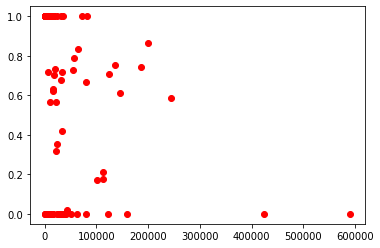

In [64]:
%%time
#teste crf num conjunto de imagens
score=0
model.load_weights('./resnet18_masati.h5')
test_dataset = Dataset(
    x_testbb4_dir, 
    y_testbb4_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
    )

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

mu1 = 1
theta_a = 1
theta_b = 4
mu2 = 5
theta_r = 3

res_size_crf=[]
res_iou_crf=[]


total_score=0
for i in range(len(test_dataset)): 
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    #pr_mask = model.predict(image).round()
    
    pr_mask = model.predict(image)

    test=1-pr_mask
    a=[]
    a.append(test[0])
    a.append(pr_mask[0])
    arr = np.array(a).squeeze() 
    img = image[0]

    softmax=arr
    unary = unary_from_softmax(softmax, scale=0.5)
    unary = np.ascontiguousarray(unary)
    unary = unary.reshape((2,-1))

    d = dcrf.DenseCRF(img.shape[0]* img.shape[1], 2)
    d.setUnaryEnergy(unary)

    #theta_a = alpha
    #theta_b = b

    feats = create_pairwise_bilateral(sdims=(theta_a, theta_a), schan=(theta_b,), img=img,  chdim=2)
    d.addPairwiseEnergy(feats, compat=mu1, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

    feats = create_pairwise_gaussian(sdims=(theta_r, theta_r), shape=img.shape[:2])
    d.addPairwiseEnergy(feats, compat=mu2, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

    Q = d.inference(10)
    res1 = np.argmax(Q, axis=0).astype('float32').reshape((img.shape[0], img.shape[1]))

    #CALCULAR A iou da imagem

    intersection = np.sum(gt_mask.squeeze() * res1)
    union = np.sum(gt_mask.squeeze() + res1) - intersection
    if union==0:
        score=1
    else:
        score = intersection / union
    res_size_crf.append(res1.shape[0]*res1.shape[1])
    res_iou_crf.append(score)
plt.plot(res_size_crf, res_iou_crf,'ro')

print(res_iou_crf.count(0.0))
print(res_iou_crf.count(1.0))



49
301


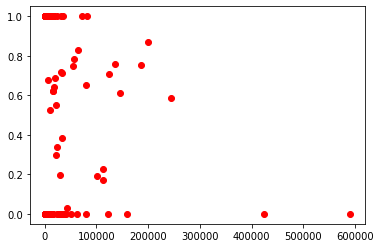

In [65]:
##(size,iou)

res_iou=[]
res_size=[]
model.load_weights('./resnet18_masati.h5')
test_dataset = Dataset(
    x_testbb4_dir, 
    y_testbb4_dir, 
    classes=CLASSES,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
    )
    
test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

total_score=0

for i in range(len(test_dataset)):
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    intersection = np.sum(gt_mask * pr_mask[0])
    union = np.sum(gt_mask + pr_mask[0]) - intersection
    if union==0:
        score=1
    else:
        score = (intersection) / (union)
    res_size.append(pr_mask[0].shape[0]*pr_mask[0].shape[1])
    res_iou.append(score)
plt.plot(res_size, res_iou,'ro')
print(res_iou.count(0.0))
print(res_iou.count(1.0))



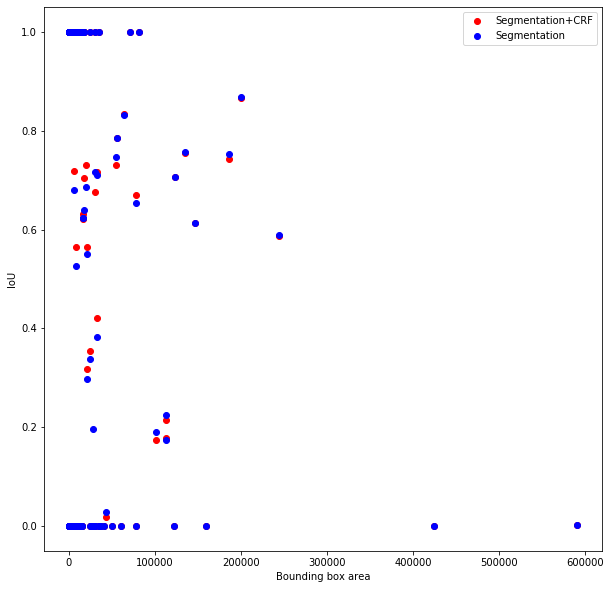

In [66]:
plt.figure(figsize=(10,10))
plt.plot(res_size_crf, res_iou_crf,'ro', label="Segmentation+CRF")
plt.plot(res_size, res_iou,'bo',label="Segmentation")
plt.ylabel('IoU')
plt.xlabel('Bounding box area')
plt.legend()
plt.show()

No handles with labels found to put in legend.


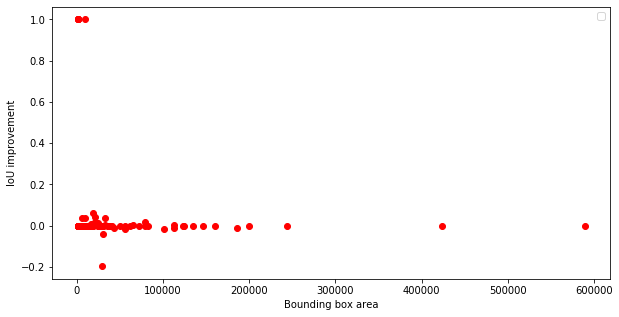

In [67]:
iou_improve=[]
for i in range(len(res_iou_crf)):
    iou_improve.append(res_iou_crf[i]-res_iou[i])

plt.figure(figsize=(10,5))    
plt.plot(res_size_crf, iou_improve, 'ro')
plt.ylabel('IoU improvement')
plt.xlabel('Bounding box area')
plt.legend()
plt.show()

In [43]:
sizes=list(set(res_size))
print(sizes)
iou_mean=[]
iou_sizes=[]
score=0
for size in sizes:
    score=0
    count=0
    for i, r_size in enumerate(res_size):
        if r_size==size:           
            score+=res_iou[i]
            count+=1
    
    iou_mean.append(score/count)
    iou_sizes.append(size)

[16384, 1024, 20480, 30720, 24576, 57344, 4096, 15360, 40960, 21504, 28672, 8192, 12288, 9216, 156672, 25600, 6144, 2048, 10240, 43008, 14336, 35840, 3072]


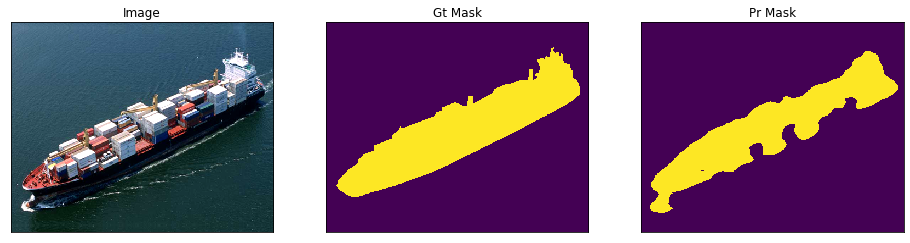

In [319]:
model.load_weights('./resnet18/resnet18_best_model.h5')
test_dataset = Dataset(
    x_img_detail_dir, 
    y_img_detail_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
    )

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

n = 1
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )

In [320]:
intersection = np.sum(gt_mask * pr_mask[0])
union = np.sum(gt_mask + pr_mask[0]) - intersection
if union==0:
    score=1
else:
    score = intersection / union 
print(score)

0.749435720699949


In [321]:
#teste crf numa imagens
score=0

mu1 = 10
theta_a = 50
theta_b = 10
mu2 = 12
theta_r = 20

num_images=0
total_score=0


pr_mask = model.predict(image)

test=1-pr_mask
a=[]
a.append(test[0])
a.append(pr_mask[0])
arr = np.array(a).squeeze() 
img = image[0]

softmax=arr
unary = unary_from_softmax(softmax, scale=0.5)
unary = np.ascontiguousarray(unary)
unary = unary.reshape((2,-1))

d = dcrf.DenseCRF(img.shape[0]* img.shape[1], 2)
d.setUnaryEnergy(unary)

#theta_a = alpha
#theta_b = b

feats = create_pairwise_bilateral(sdims=(theta_a, theta_a), schan=(theta_b,), img=img,  chdim=2)
d.addPairwiseEnergy(feats, compat=mu1, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

feats = create_pairwise_gaussian(sdims=(theta_r, theta_r), shape=img.shape[:2])
d.addPairwiseEnergy(feats, compat=mu2, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

Q = d.inference(20)
res1 = np.argmax(Q, axis=0).astype('float32').reshape((img.shape[0], img.shape[1]))



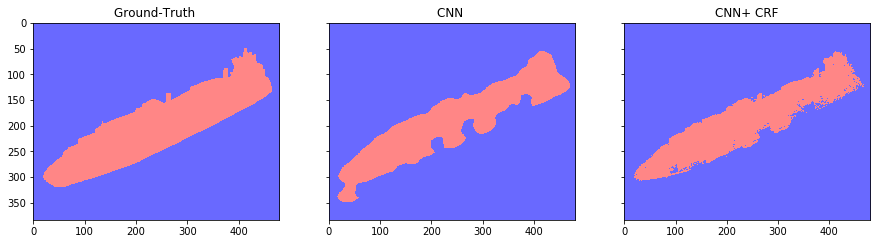

In [322]:
cmap1 = plt.get_cmap('bwr')

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,15))

ax1.imshow(gt_mask[..., 0].squeeze().round(), vmax=1.5, vmin=-0.4, cmap=cmap1)
ax1.set_title('Ground-Truth ')

ax3.imshow(res1, vmax=1.5, vmin=-0.4, cmap=cmap1)
ax3.set_title('CNN+ CRF')

ax2.imshow(pr_mask[..., 0].squeeze().round(), vmax=1.5, vmin=-0.4, cmap=cmap1)
ax2.set_title('CNN ')



plt.show()

In [323]:
intersection = np.sum(gt_mask.squeeze() * res1)
union = np.sum(gt_mask.squeeze() + res1) - intersection
if union==0:
    score=1
else:
    score = intersection / union
print(score)

0.7626955597184952


In [170]:
false_negatives=0
true_positives=0
true_negatives=0
false_positives=0
total_boats=0
iou_total=0
for i in range(len(test_dataset)):
    print("iteração: "+ str(i))    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    if np.sum(gt_mask)!=0:
        total_boats+=1
    if np.sum(gt_mask)==0 and np.sum(pr_mask)==0:
        print("sem barco")
        true_negatives+=1
    elif np.sum(gt_mask)!=0 and np.sum(pr_mask)==0:
        false_negatives+=1
    elif np.sum(gt_mask)==0 and np.sum(pr_mask)!=0:
        false_positives+=1
    else:        
        #print("pixeis barco na gt")
        #print(np.sum(gt_mask))
        #print("pixeis barco na predita")
        #print(np.sum(pr_mask))
        intersection = np.logical_and(gt_mask, pr_mask)
        union = np.logical_or(pr_mask,gt_mask)
        i=np.sum(intersection)
        u= np.sum(union)
        iou_score = i / u
        iou_total=iou_total+iou_score
        print(iou_score)
        if iou_score>=0.5:
            true_positives+=1

iteração: 0
0.8208412397216951
iteração: 1
sem barco
iteração: 2
sem barco
iteração: 3
sem barco
iteração: 4
sem barco
iteração: 5
0.8610855565777369
iteração: 6
sem barco
iteração: 7
sem barco
iteração: 8
sem barco
iteração: 9
sem barco
iteração: 10
sem barco
iteração: 11
0.31629297458893874
iteração: 12
sem barco
iteração: 13
0.8813389121338913
iteração: 14
sem barco
iteração: 15
sem barco
iteração: 16
0.8711808422791082
iteração: 17
sem barco
iteração: 18
sem barco
iteração: 19
sem barco
iteração: 20
0.8465335908993347
iteração: 21
0.5520833333333334
iteração: 22
0.04582810976459117
iteração: 23
0.8265360169491526
iteração: 24
0.6831023454157783
iteração: 25
iteração: 26
sem barco
iteração: 27
sem barco
iteração: 28
0.6132672722268098
iteração: 29
0.37922291509627903
iteração: 30
sem barco
iteração: 31
0.4555466879489226
iteração: 32
0.7690692792162351
iteração: 33
0.38628452077048037
iteração: 34
0.8206806282722513
iteração: 35
iteração: 36
sem barco
iteração: 37
0.3202869280590570

sem barco
iteração: 339
sem barco
iteração: 340
sem barco
iteração: 341
sem barco
iteração: 342
sem barco
iteração: 343
sem barco
iteração: 344
sem barco
iteração: 345
sem barco
iteração: 346
sem barco
iteração: 347
sem barco
iteração: 348
sem barco
iteração: 349
sem barco
iteração: 350
sem barco
iteração: 351
0.8046958377801494
iteração: 352
sem barco
iteração: 353
iteração: 354
sem barco
iteração: 355
sem barco
iteração: 356
sem barco
iteração: 357
sem barco
iteração: 358
sem barco
iteração: 359
iteração: 360
sem barco
iteração: 361
sem barco
iteração: 362
sem barco
iteração: 363
sem barco
iteração: 364
sem barco
iteração: 365
sem barco
iteração: 366
0.8455592364726298
iteração: 367
sem barco
iteração: 368
sem barco
iteração: 369
sem barco
iteração: 370
sem barco
iteração: 371
sem barco
iteração: 372
sem barco
iteração: 373
sem barco
iteração: 374
sem barco
iteração: 375
sem barco
iteração: 376
sem barco
iteração: 377
sem barco
iteração: 378
sem barco
iteração: 379
sem barco
iteração

In [171]:
print("total boats: "+ str(total_boats))
print("true_positives: "+ str(true_positives))
print("true_negatives: "+str(true_negatives))
print("false_positives: "+ str(false_positives))
print("false_negatives: "+str(false_negatives))



total boats: 53
true_positives: 32
true_negatives: 413
false_positives: 28
false_negatives: 2


In [39]:
import json
model.load_weights('best_model - 10epochs.h5')
test_dataset = Dataset(
    x_testkaggle_dir, 
    y_testkaggle_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)
for i in range(len(test_dataset)):
    print(i)
    print(test_dataset.ids[i])
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    name,ext=test_dataset.ids[i].split('.')
    with open('./resultskaggle/'+name+'.txt', 'w') as outfile:
        json.dump({"filename":test_dataset.ids[i], "pr_mask":pr_mask[0].tolist(), "gt_mask": gt_mask.tolist()}, outfile)    

0
06f8a3862_1.png
1
06f8a3862_10.png
2
06f8a3862_11.png
3
06f8a3862_12.png
4
06f8a3862_13.png
5
06f8a3862_14.png
6
06f8a3862_15.png
7
06f8a3862_16.png
8
06f8a3862_2.png
9
06f8a3862_3.png
10
06f8a3862_4.png
11
06f8a3862_5.png
12
06f8a3862_6.png
13
06f8a3862_7.png
14
06f8a3862_8.png
15
06f8a3862_9.png
16
06fabf390_1.png
17
06fabf390_10.png
18
06fabf390_11.png
19
06fabf390_2.png
20
06fabf390_3.png
21
06fabf390_4.png
22
06fabf390_5.png
23
06fabf390_6.png
24
06fabf390_7.png
25
06fabf390_8.png
26
06fabf390_9.png
27
06fc980db_1.png
28
06fc980db_2.png
29
06fc980db_3.png
30
06fca7a3f_1.png
31
06fca7a3f_2.png
32
06fca7a3f_3.png
33
06fca7a3f_4.png
34
06fca7a3f_5.png
35
06fdbf61d_1.png
36
06fdbf61d_2.png
37
06fdbf61d_3.png
38
06fe2c67c_1.png
39
06fe2c67c_2.png
40
06fe2c67c_3.png
41
06fe2c67c_4.png
42
06fe2c67c_5.png
43
06fe2c67c_6.png
44
06fe2c67c_7.png
45
06fe2c67c_8.png
46
06fe2c67c_9.png
47
06fe43ec3_1.png
48
06fe43ec3_2.png
49
06fe43ec3_3.png
50
06fe43ec3_4.png
51
06fe43ec3_5.png
52
06fe43ec3_

In [14]:
import json
model.load_weights('./inceptionresnetv2_kaggle2_trainseg4_focal_weighteddl__batch8_1_50epochs.h5')
test_dataset = Dataset(
    x_challenge_dir, 
    y_challenge_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)
for i in range(len(test_dataset)):
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    #pr_mask = model.predict(image)
    #pr_mask=pr_mask+0.6
    #pr_mask=np.floor(pr_mask)
    name,ext=test_dataset.ids[i].split('.')
    with open('../airbus-ship-detection/input/challenge/results_train_seg4_focal_weighteddl__batch8_1_inceptionresnetv2_50epochs/'+name+'.txt', 'w') as outfile:
        json.dump({"filename":test_dataset.ids[i], "pr_mask":pr_mask[0].tolist()}, outfile) 

In [15]:
x_clip_dir = '../clip/cut_images/'
y_clip_dir = '../clip/cut_annot/'

import json
model.load_weights('./densenet121_kaggle2_trainseg4_focal_weighteddl__batch8_1_50epochs.h5')
test_dataset = Dataset(
    x_clip_dir, 
    y_clip_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)
for i in range(len(test_dataset)):
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    #pr_mask = model.predict(image)
    #pr_mask=pr_mask+0.6
    #pr_mask=np.floor(pr_mask)
    name,ext=test_dataset.ids[i].split('.')
    with open('../clip/seg_results/'+name+'.txt', 'w') as outfile:
        json.dump({"filename":test_dataset.ids[i], "pr_mask":pr_mask[0].tolist()}, outfile) 

In [18]:
%%time
model.load_weights('./resnet18_kaggle2_trainseg4_focal_weighteddl__batch16_16.h5')
test_dataset = Dataset(
    x_testbbseagull_dir, 
    y_testbbseagull_dir, 
    classes=CLASSES,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
    )
    
test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

total_score=0

for i in range(len(test_dataset)):
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    intersection = np.sum(gt_mask * pr_mask[0])
    union = np.sum(gt_mask + pr_mask[0]) - intersection
    if union==0:
        score=1
    else:
        score = (intersection) / (union)
    total_score+=score
print(total_score/len(test_dataset))
print("numero de bb= "+str(len(test_dataset)))

0.9109089645523081
numero de bb= 494
Wall time: 9.47 s


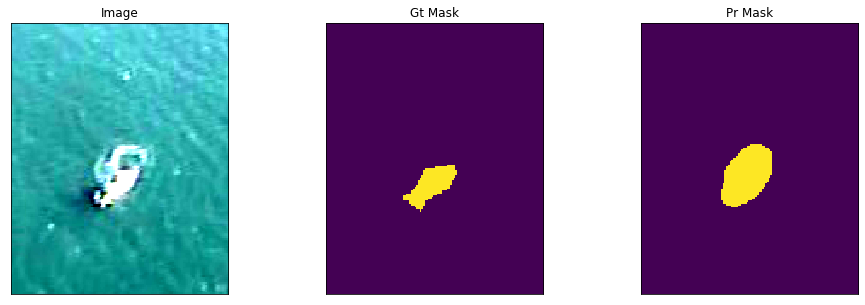

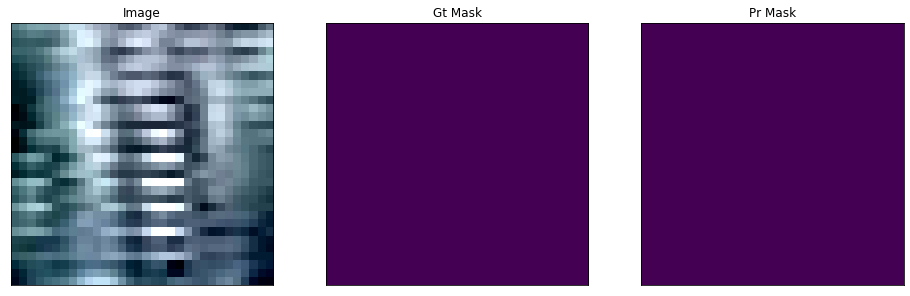

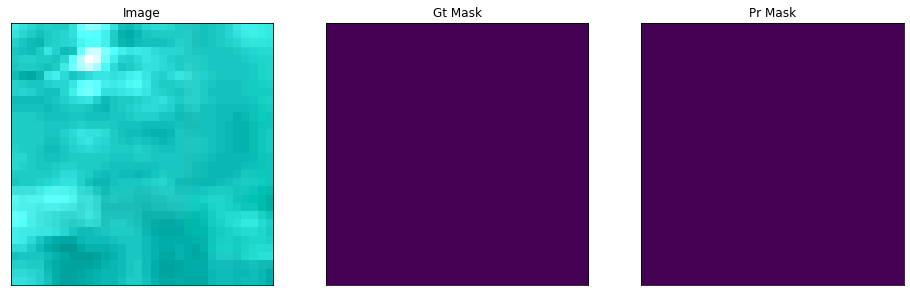

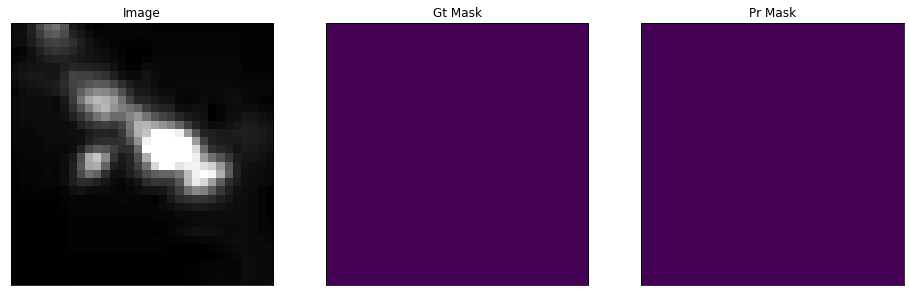

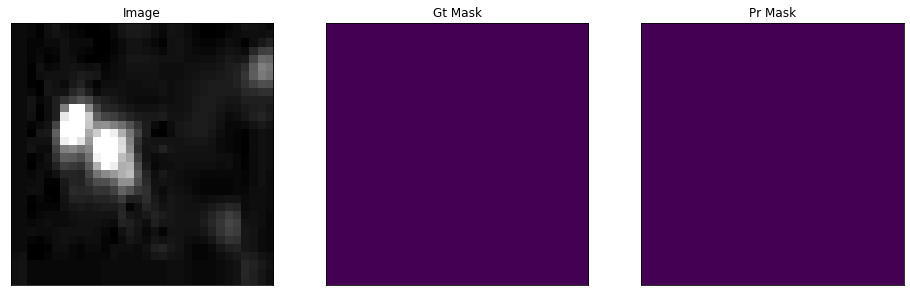

In [71]:
import json
model.load_weights('./resnet18_kaggle2_trainseg4_focal_weighteddl__batch16_16.h5')
test_dataset = Dataset(
    x_testbbseagull_dir, 
    y_testbbseagull_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )

In [44]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, None, None, 3 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d_1[0][0]           
____________________________________________________________________________________________

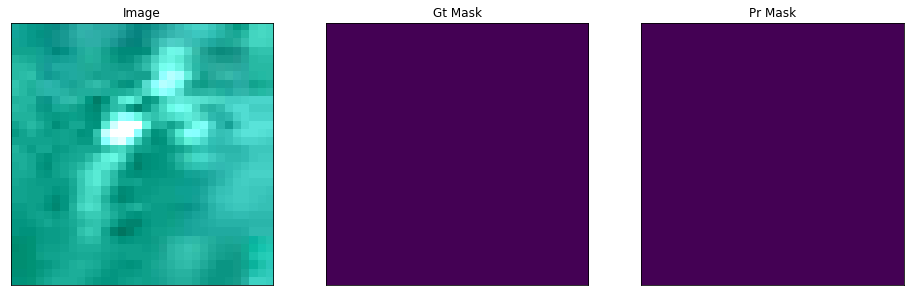

tf.Tensor(1.0, shape=(), dtype=float64)


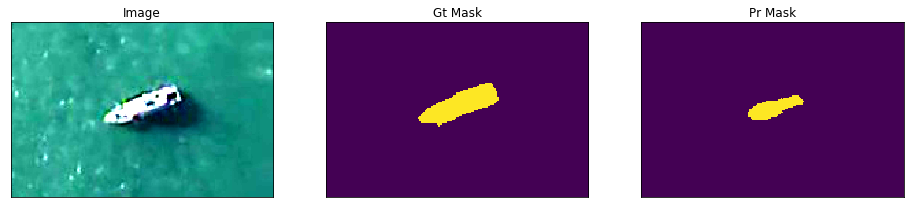

tf.Tensor(0.44380733944954764, shape=(), dtype=float64)


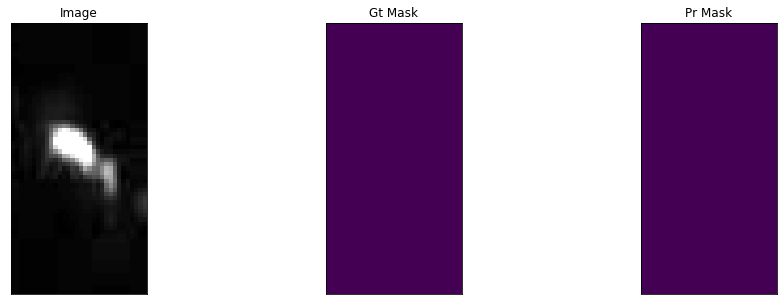

tf.Tensor(1.0, shape=(), dtype=float64)


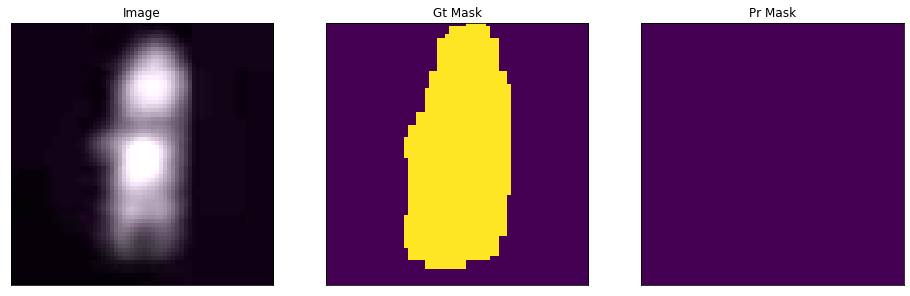

tf.Tensor(7.961783439490382e-15, shape=(), dtype=float64)


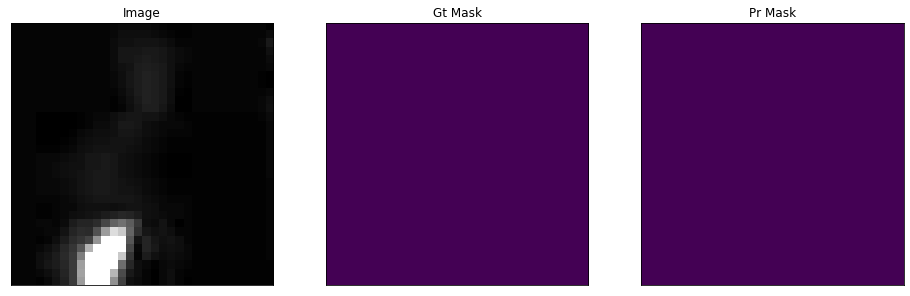

tf.Tensor(1.0, shape=(), dtype=float64)


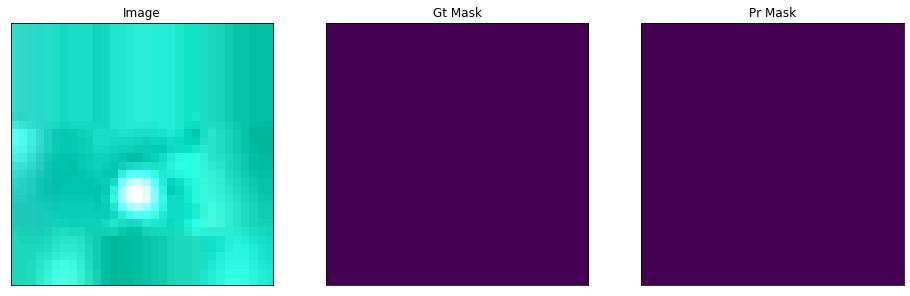

tf.Tensor(1.0, shape=(), dtype=float64)


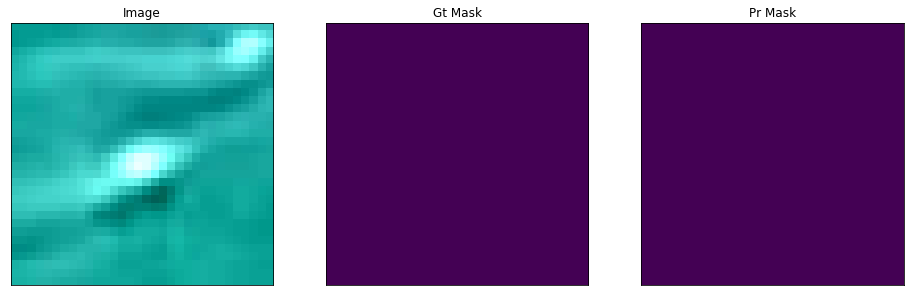

tf.Tensor(1.0, shape=(), dtype=float64)


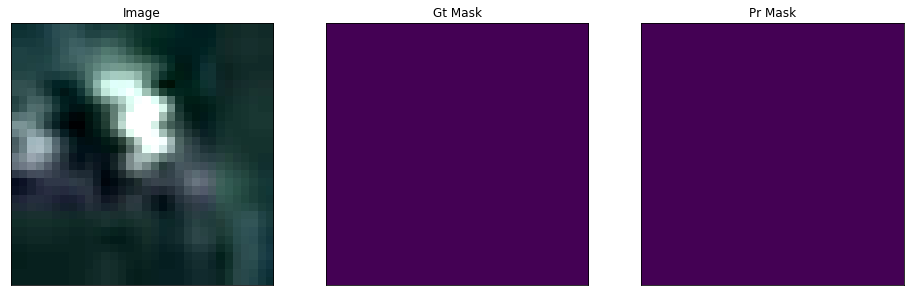

tf.Tensor(1.0, shape=(), dtype=float64)


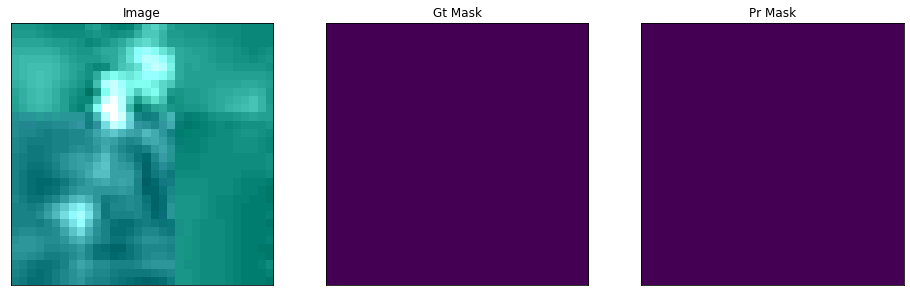

tf.Tensor(1.0, shape=(), dtype=float64)


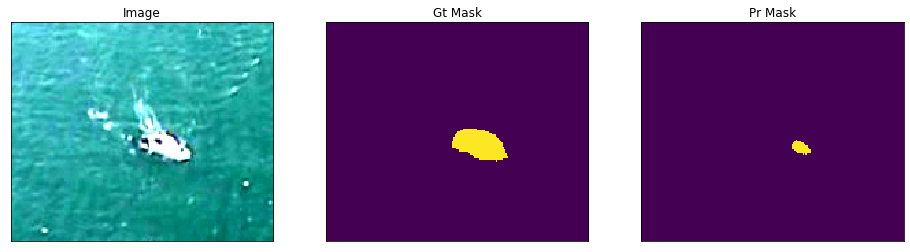

tf.Tensor(0.14479638009051063, shape=(), dtype=float64)


In [43]:
#testar a métrica IoU
from segmentation_models.metrics import IOUScore, FScore

import json
model.load_weights('./resnet18_kaggle2_trainseg4_focal_weighteddl__batch16.h5')
test_dataset = Dataset(
    x_testbbseagull_dir, 
    y_testbbseagull_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

n = 10
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )

    iou_score = IOUScore(smooth=10e-12)
    score=iou_score(gt_mask, pr_mask)
    print(score)

In [15]:
#com crf
import json
model.load_weights('./resnet18_kaggle2_trainseg4_focal_weighteddl__batch16.h5')
test_dataset = Dataset(
    x_challenge_dir, 
    y_challenge_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

mu1 = 1
theta_a = 1
theta_b = 4
mu2 = 5
theta_r = 3

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)
for i in range(len(test_dataset)):
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    #pr_mask = model.predict(image).round()
    pr_mask = model.predict(image)

    test=1-pr_mask
    a=[]
    a.append(test[0])
    a.append(pr_mask[0])
    arr = np.array(a).squeeze() 
    img = image[0]

    softmax=arr
    unary = unary_from_softmax(softmax, scale=0.5)
    unary = np.ascontiguousarray(unary)
    unary = unary.reshape((2,-1))

    d = dcrf.DenseCRF(img.shape[0]* img.shape[1], 2)
    d.setUnaryEnergy(unary)

    #theta_a = alpha
    #theta_b = b

    feats = create_pairwise_bilateral(sdims=(theta_a, theta_a), schan=(theta_b,), img=img,  chdim=2)
    d.addPairwiseEnergy(feats, compat=mu1, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

    feats = create_pairwise_gaussian(sdims=(theta_r, theta_r), shape=img.shape[:2])
    d.addPairwiseEnergy(feats, compat=mu2, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

    Q = d.inference(10)
    res1 = np.argmax(Q, axis=0).astype('float32').reshape((img.shape[0], img.shape[1]))
    
    name,ext=test_dataset.ids[i].split('.')
    
    
    with open('../airbus-ship-detection/input/challenge/results_train_seg4_focal_weighteddl__batch16_com_CRF/'+name+'.txt', 'w') as outfile:
        json.dump({"filename":test_dataset.ids[i], "pr_mask":res1.tolist()}, outfile) 

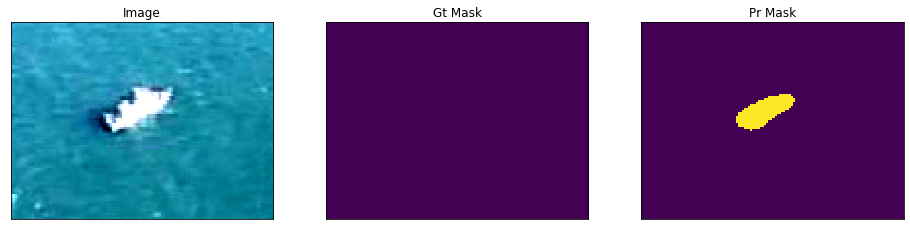

2015-04-22-18-29-31_tase_frame78_6.png


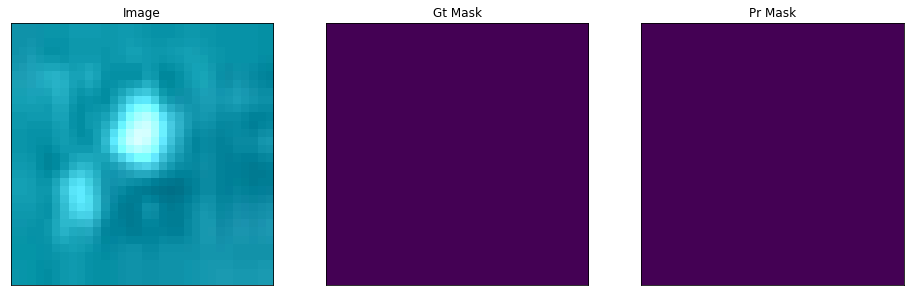

2015-04-22-18-29-31_tase_frame299_12.png


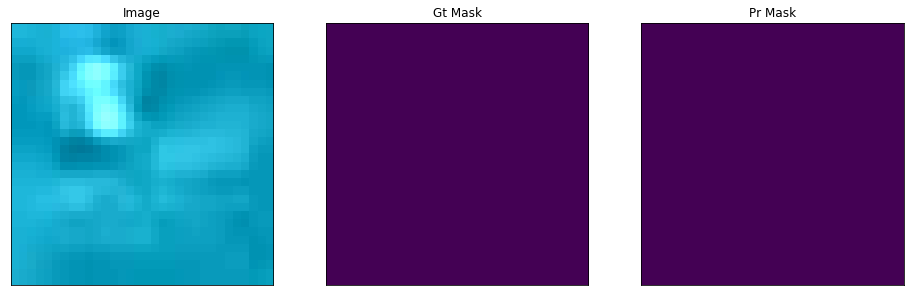

2015-04-22-18-29-31_tase_frame255_19.png


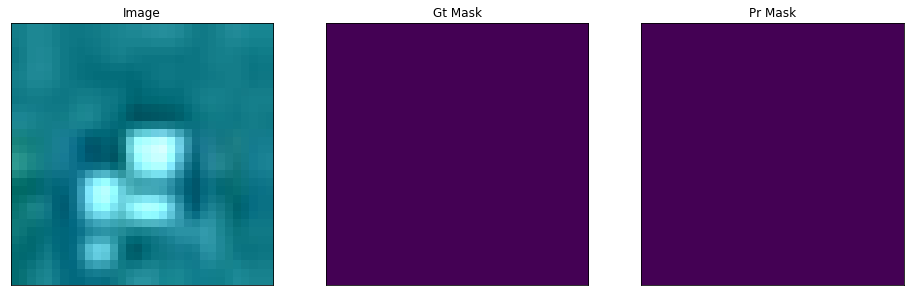

2015-04-22-18-29-31_tase_frame164_20.png


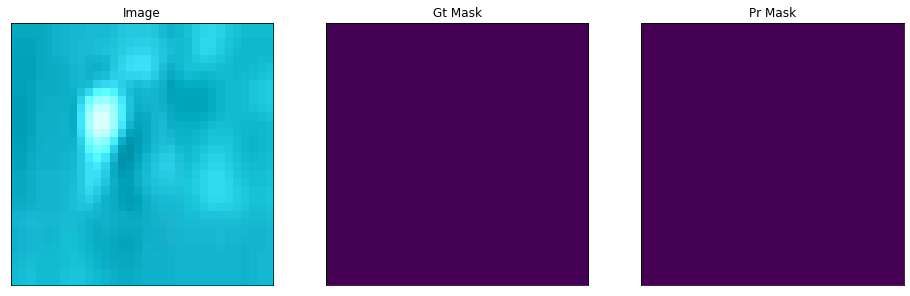

2015-04-22-18-29-31_tase_frame134_17.png


In [26]:
#resultado em algumas imagens com crf vs sem crf

import json
model.load_weights('./densenet121_kaggle2_trainseg4_focal_weighteddl__batch8_1_50epochs.h5')
test_dataset = Dataset(
    x_clip_dir, 
    y_clip_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )
    print(test_dataset.ids[i])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


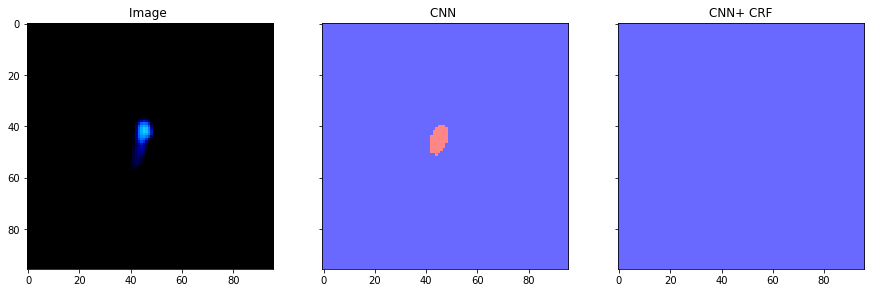

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


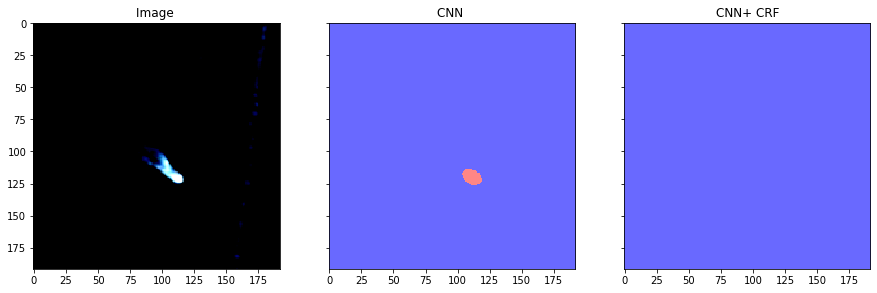

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


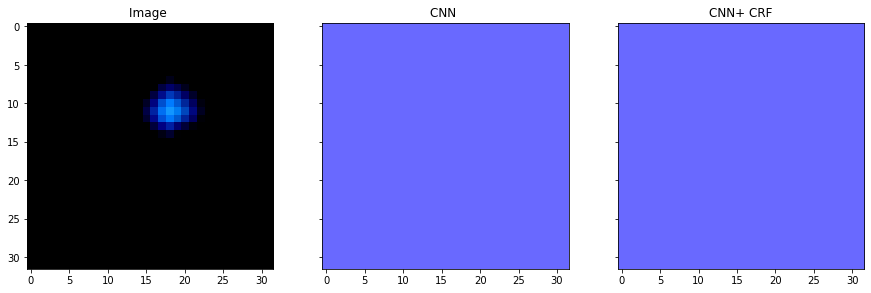

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


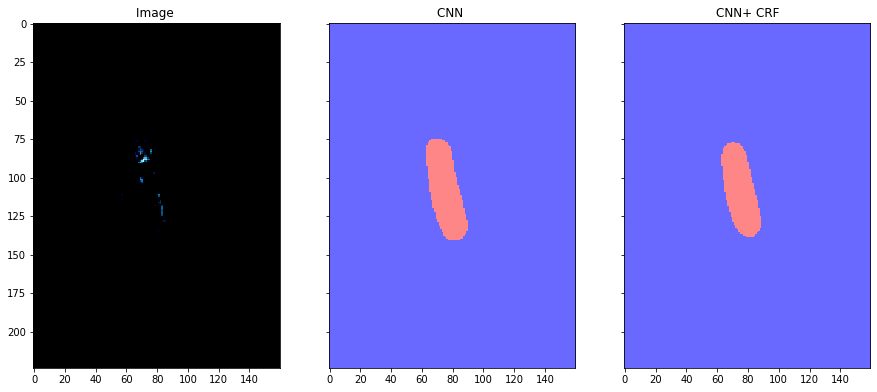

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


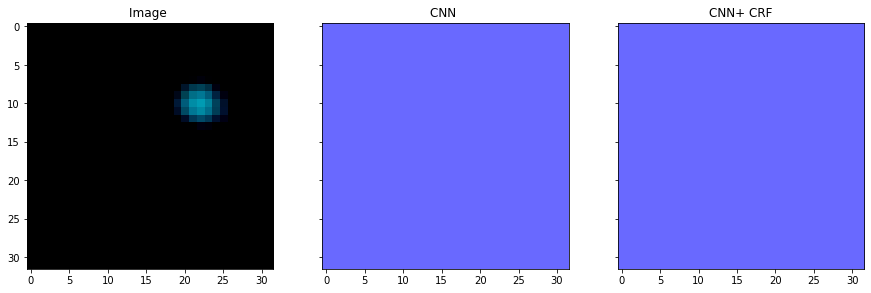

In [25]:

mu1 = 1
theta_a = 1
theta_b = 4
mu2 = 5
theta_r = 3
for i in ids:
    if i%100==0:
        print(i)
    #image, gt_mask = test_dataset[i]
    #image = np.expand_dims(image, axis=0)
    #pr_mask = model.predict(image).round()
    #mask=pr_mask[0]
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    #pr_mask = model.predict(image).round()
    
    pr_mask = model.predict(image)

    test=1-pr_mask
    a=[]
    a.append(test[0])
    a.append(pr_mask[0])
    arr = np.array(a).squeeze() 
    img = image[0]

    softmax=arr
    unary = unary_from_softmax(softmax, scale=0.5)
    unary = np.ascontiguousarray(unary)
    unary = unary.reshape((2,-1))

    d = dcrf.DenseCRF(img.shape[0]* img.shape[1], 2)
    d.setUnaryEnergy(unary)

    #theta_a = alpha
    #theta_b = b

    feats = create_pairwise_bilateral(sdims=(theta_a, theta_a), schan=(theta_b,), img=img,  chdim=2)
    d.addPairwiseEnergy(feats, compat=mu1, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

    feats = create_pairwise_gaussian(sdims=(theta_r, theta_r), shape=img.shape[:2])
    d.addPairwiseEnergy(feats, compat=mu2, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

    Q = d.inference(10)
    res1 = np.argmax(Q, axis=0).astype('float32').reshape((img.shape[0], img.shape[1]))

    mask=res1
    #plt.figure()
    #plt.imshow(mask)
    
    cmap1 = plt.get_cmap('bwr')

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,15))

    ax1.imshow(image.squeeze(), vmax=1.5, vmin=-0.4, cmap=cmap1)
    ax1.set_title('Image ')

    ax3.imshow(res1, vmax=1.5, vmin=-0.4, cmap=cmap1)
    ax3.set_title('CNN+ CRF')

    ax2.imshow(pr_mask[..., 0].squeeze().round(), vmax=1.5, vmin=-0.4, cmap=cmap1)
    ax2.set_title('CNN ')



    plt.show()